In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm  

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f" Using device: {device}")

 Using device: cuda


In [29]:
# Configuration
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
DATA_DIR = 'data/classification_dataset'

# Define Transforms
train_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load Folders
train_data = datasets.ImageFolder(f'{DATA_DIR}/train', transform=train_transforms)
val_data   = datasets.ImageFolder(f'{DATA_DIR}/valid', transform=val_transforms)
test_data = datasets.ImageFolder(f'{DATA_DIR}/test', transform=val_transforms)

# Create Loaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Data Ready: {len(train_data)} Train images, {len(val_data)} Val images")

Data Ready: 2662 Train images, 442 Val images


In [19]:
# Model Architecture
class DroneBirdCNN(nn.Module):
    def __init__(self):
        super(DroneBirdCNN, self).__init__()
        
        # Block 1: Detects simple features (edges, colors)
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),       # Stabilizes learning
            nn.ReLU(),                # Adds non-linearity (allows complex patterns)
            nn.MaxPool2d(kernel_size=2, stride=2) # Reduces size: 224 -> 112
        )
        
        # Block 2: Detects shapes (circles, corners)
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)        # Reduces size: 112 -> 56
        )
        
        # Block 3: Detects complex objects (wings, rotors)
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)        # Reduces size: 56 -> 28
        )
        
        # Block 4: Deep abstraction
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)        # Reduces size: 28 -> 14
        )

        # Classifier: The Decision Maker
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 14 * 14, 512), # Connects features to neurons
            nn.ReLU(),
            nn.Dropout(0.5),               # Randomly shuts off 50% neurons to prevent memorization
            nn.Linear(512, 1),             # Output: 1 single number (probability)
            nn.Sigmoid()                   # Squishes output between 0 and 1
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

# Initialize model
model = DroneBirdCNN().to(device)
print(model)

DroneBirdCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padd

In [20]:
# Loss Function: measures how wrong the model is
# BCELoss is standard for Binary Classification (0 vs 1)
criterion = nn.BCELoss()

# Optimizer: adjusts the weights to reduce loss
# Adam is generally the best default choice
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store metrics for plotting later
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

print("Optimizer and Loss defined.")

Optimizer and Loss defined.


In [21]:
EPOCHS = 10
best_acc = 0.0

print(f"Starting Training for {EPOCHS} Epochs...")

for epoch in range(EPOCHS):
    # TRAIN LOOP
    model.train() # Enable Dropout/BatchNorm
    train_loss, train_correct = 0.0, 0
    
    # Tqdm creates the progress bar
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        
        optimizer.zero_grad()             # 1. Reset Gradients
        outputs = model(images)           # 2. Forward Pass
        loss = criterion(outputs, labels) # 3. Calculate Loss
        loss.backward()                   # 4. Backward Pass
        optimizer.step()                  # 5. Update Weights
        
        # Update metrics
        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        train_correct += (predicted == labels).sum().item()
        
        loop.set_postfix(loss=loss.item()) # Update progress bar text

    # VALIDATION LOOP
    model.eval() # Disable Dropout
    val_loss, val_correct = 0.0, 0
    
    with torch.no_grad(): # No gradients needed for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            val_correct += (predicted == labels).sum().item()

    # LOGGING
    # Calculate averages
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_train_acc = train_correct / len(train_data)
    avg_val_acc = val_correct / len(val_data)
    
    # Store history
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_acc'].append(avg_train_acc)
    history['val_acc'].append(avg_val_acc)
    
    print(f" Train Acc: {avg_train_acc:.4f} | Val Acc: {avg_val_acc:.4f}")

    # Save Best Model
    if avg_val_acc > best_acc:
        best_acc = avg_val_acc
        torch.save(model.state_dict(), 'best_custom_cnn.pth')
        print(f" Model Saved! (Improved to {best_acc:.4f})")

print("\nTraining Complete.")

Starting Training for 10 Epochs...


Epoch 1/10: 100%|██████████████████████████████████████████████████████████| 84/84 [00:47<00:00,  1.77it/s, loss=0.503]


 Train Acc: 0.6536 | Val Acc: 0.6833
 Model Saved! (Improved to 0.6833)


Epoch 2/10: 100%|██████████████████████████████████████████████████████████| 84/84 [00:45<00:00,  1.84it/s, loss=0.434]


 Train Acc: 0.6957 | Val Acc: 0.6991
 Model Saved! (Improved to 0.6991)


Epoch 3/10: 100%|██████████████████████████████████████████████████████████| 84/84 [00:46<00:00,  1.82it/s, loss=0.372]


 Train Acc: 0.7250 | Val Acc: 0.7489
 Model Saved! (Improved to 0.7489)


Epoch 4/10: 100%|██████████████████████████████████████████████████████████| 84/84 [00:45<00:00,  1.85it/s, loss=0.193]


 Train Acc: 0.7585 | Val Acc: 0.7919
 Model Saved! (Improved to 0.7919)


Epoch 5/10: 100%|██████████████████████████████████████████████████████████| 84/84 [00:43<00:00,  1.94it/s, loss=0.245]


 Train Acc: 0.7949 | Val Acc: 0.8145
 Model Saved! (Improved to 0.8145)


Epoch 6/10: 100%|██████████████████████████████████████████████████████████| 84/84 [00:45<00:00,  1.84it/s, loss=0.217]


 Train Acc: 0.8156 | Val Acc: 0.7557


Epoch 7/10: 100%|██████████████████████████████████████████████████████████| 84/84 [00:45<00:00,  1.83it/s, loss=0.504]


 Train Acc: 0.8140 | Val Acc: 0.8122


Epoch 8/10: 100%|█████████████████████████████████████████████████████████| 84/84 [00:46<00:00,  1.80it/s, loss=0.0746]


 Train Acc: 0.8261 | Val Acc: 0.7783


Epoch 9/10: 100%|██████████████████████████████████████████████████████████| 84/84 [00:44<00:00,  1.89it/s, loss=0.288]


 Train Acc: 0.8313 | Val Acc: 0.8394
 Model Saved! (Improved to 0.8394)


Epoch 10/10: 100%|█████████████████████████████████████████████████████████| 84/84 [00:43<00:00,  1.92it/s, loss=0.356]


 Train Acc: 0.8362 | Val Acc: 0.8439
 Model Saved! (Improved to 0.8439)

Training Complete.


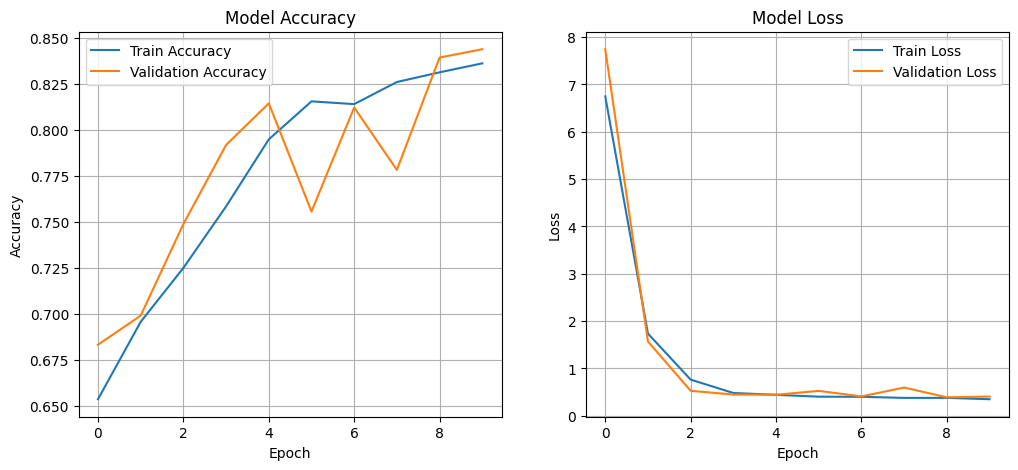

In [22]:
# Plotting the training curves
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [23]:
from torchvision import models

# Load the Pre-trained Model (The "Teacher")
transfer_model = models.resnet18(weights='DEFAULT')

# Freeze the Base Layers (Lock the Knowledge)
for param in transfer_model.parameters():
    param.requires_grad = False

# Replace the "Head" (The Decision Maker)
num_features = transfer_model.fc.in_features  # Get the input size of the last layer

transfer_model.fc = nn.Sequential(
    nn.Linear(num_features, 256), # Add a small intermediate layer
    nn.ReLU(),
    nn.Dropout(0.5),              # Safety mechanism against overfitting
    nn.Linear(256, 1),            # Output: 1 single score
    nn.Sigmoid()                  # Squash to 0-1
)

# Move to GPU
transfer_model = transfer_model.to(device)

print("Transfer Learning Model (ResNet18) ready!")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\comra/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


Transfer Learning Model (ResNet18) ready!


In [24]:
# Load the Pre-trained Model (The "Teacher")
print("Loading ResNet18...")
transfer_model = models.resnet18(weights='DEFAULT')

# Freeze the Base Layers (Lock the Knowledge)
for param in transfer_model.parameters():
    param.requires_grad = False

# Replace the "Head" (The Decision Maker)
num_features = transfer_model.fc.in_features

transfer_model.fc = nn.Sequential(
    nn.Linear(num_features, 256), # Intermediate layer
    nn.ReLU(),
    nn.Dropout(0.5),              # Drop 50% neurons to prevent overfitting
    nn.Linear(256, 1),            # Output: 1 single score
    nn.Sigmoid()                  # Squash to 0-1
)

# Move to GPU
transfer_model = transfer_model.to(device)

# Setup Optimizer & Loss
optimizer = optim.Adam(filter(lambda p: p.requires_grad, transfer_model.parameters()), lr=0.001)
criterion = nn.BCELoss()

EPOCHS = 10 
best_val_acc = 0.0

print(f"Starting Transfer Learning for {EPOCHS} Epochs...")

# TRAINING LOOP
for epoch in range(EPOCHS):
    # TRAIN PHASE
    transfer_model.train()
    train_loss = 0
    train_correct = 0
    
    # Progress bar
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        
        optimizer.zero_grad()             # 1. Reset gradients
        outputs = transfer_model(images)  # 2. Forward pass
        loss = criterion(outputs, labels) # 3. Calculate loss
        loss.backward()                   # 4. Backward pass
        optimizer.step()                  # 5. Update weights
        
        # Metrics
        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        train_correct += (predicted == labels).sum().item()
        
        loop.set_postfix(loss=loss.item())
        
    # VALIDATION PHASE
    transfer_model.eval()
    val_loss = 0
    val_correct = 0
    
    with torch.no_grad(): # Save memory, don't calculate gradients
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            
            outputs = transfer_model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            
    # CALCULATE & PRINT STATS
    avg_train_acc = train_correct / len(train_data)
    avg_val_acc = val_correct / len(val_data)
    
    print(f" Train Acc: {avg_train_acc:.4f} | Val Acc: {avg_val_acc:.4f}")

    # SAVE BEST MODEL
    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        torch.save(transfer_model.state_dict(), 'best_transfer_model.pth')
        print(f" New Best Model Saved! ({best_val_acc:.4f})")

print(f"\nFinal Best Accuracy: {best_val_acc:.4f}")

Loading ResNet18...
Starting Transfer Learning for 10 Epochs...


Epoch 1/10: 100%|██████████████████████████████████████████████████████████| 84/84 [00:44<00:00,  1.88it/s, loss=0.224]


 Train Acc: 0.8948 | Val Acc: 0.9412
 New Best Model Saved! (0.9412)


Epoch 2/10: 100%|██████████████████████████████████████████████████████████| 84/84 [00:44<00:00,  1.88it/s, loss=0.216]


 Train Acc: 0.9365 | Val Acc: 0.9457
 New Best Model Saved! (0.9457)


Epoch 3/10: 100%|██████████████████████████████████████████████████████████| 84/84 [00:44<00:00,  1.90it/s, loss=0.126]


 Train Acc: 0.9444 | Val Acc: 0.9367


Epoch 4/10: 100%|████████████████████████████████████████████████████████████| 84/84 [00:44<00:00,  1.88it/s, loss=0.9]


 Train Acc: 0.9534 | Val Acc: 0.9457


Epoch 5/10: 100%|█████████████████████████████████████████████████████████| 84/84 [00:44<00:00,  1.90it/s, loss=0.0924]


 Train Acc: 0.9414 | Val Acc: 0.9502
 New Best Model Saved! (0.9502)


Epoch 6/10: 100%|██████████████████████████████████████████████████████████| 84/84 [00:44<00:00,  1.90it/s, loss=0.275]


 Train Acc: 0.9527 | Val Acc: 0.9570
 New Best Model Saved! (0.9570)


Epoch 7/10: 100%|█████████████████████████████████████████████████████████| 84/84 [00:43<00:00,  1.91it/s, loss=0.0104]


 Train Acc: 0.9557 | Val Acc: 0.9276


Epoch 8/10: 100%|█████████████████████████████████████████████████████████| 84/84 [00:43<00:00,  1.92it/s, loss=0.0698]


 Train Acc: 0.9564 | Val Acc: 0.9615
 New Best Model Saved! (0.9615)


Epoch 9/10: 100%|██████████████████████████████████████████████████████████| 84/84 [00:44<00:00,  1.88it/s, loss=0.235]


 Train Acc: 0.9452 | Val Acc: 0.9593


Epoch 10/10: 100%|█████████████████████████████████████████████████████████| 84/84 [00:30<00:00,  2.72it/s, loss=0.938]


 Train Acc: 0.9587 | Val Acc: 0.9615

Final Best Accuracy: 0.9615


In [31]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import pandas as pd
import numpy as np

def evaluate_model(model, loader, model_name="Model"):
    model.eval() # Set to evaluation mode
    all_preds = []
    all_labels = []
    
    print(f"Evaluating {model_name}...")
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            
            # Move to CPU and convert to numpy for sklearn
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Flatten lists
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()
    
    # Calculate Metrics
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    cm = confusion_matrix(all_labels, all_preds)
    
    return {
        "name": model_name,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm,
        "preds": all_preds,
        "labels": all_labels
    }

print("Evaluation function ready.")

Evaluation function ready.


In [34]:
# Re-initialize Architectures
# Custom CNN
custom_model = DroneBirdCNN().to(device)
custom_model.load_state_dict(torch.load('best_custom_cnn.pth', weights_only=True))

# Transfer Learning (ResNet18)
transfer_model = models.resnet18(weights=None) # No weights needed, we load our own
num_ftrs = transfer_model.fc.in_features
transfer_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 1),
    nn.Sigmoid()
)
transfer_model = transfer_model.to(device)
transfer_model.load_state_dict(torch.load('best_transfer_model.pth', weights_only=True))

# Run Evaluation on TEST Data 
results_cnn = evaluate_model(custom_model, test_loader, "Custom CNN")
results_transfer = evaluate_model(transfer_model, test_loader, "ResNet18 (Transfer)")

print("\nEvaluation Complete!")

Evaluating Custom CNN...
Evaluating ResNet18 (Transfer)...

Evaluation Complete!


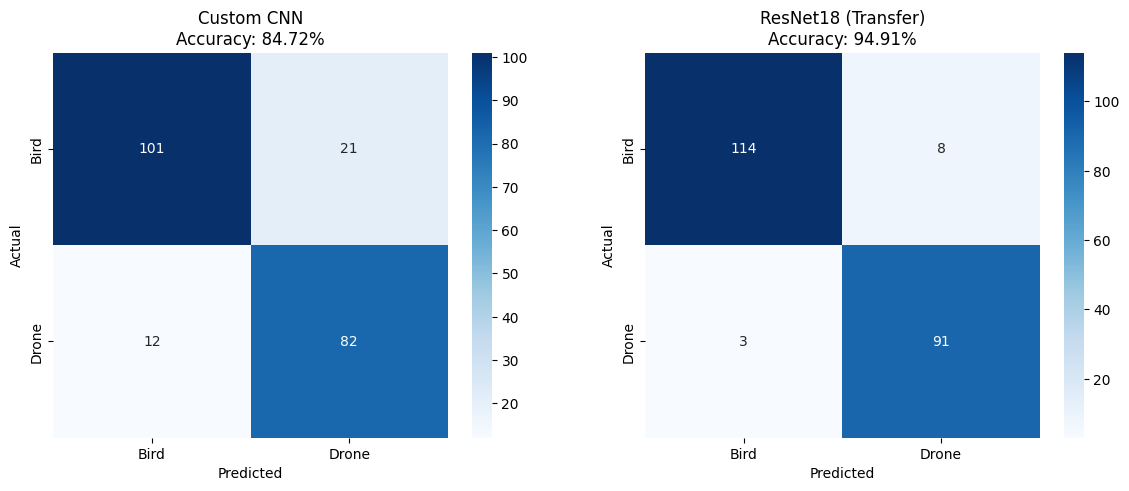

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Helper to plot heatmap
def plot_cm(results, ax):
    sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Bird', 'Drone'], yticklabels=['Bird', 'Drone'])
    ax.set_title(f"{results['name']}\nAccuracy: {results['accuracy']:.2%}")
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

# Plot both
plot_cm(results_cnn, axes[0])
plot_cm(results_transfer, axes[1])

plt.show()

In [36]:
# Create a comparison table
comparison_data = [
    [results_cnn['name'], results_cnn['accuracy'], results_cnn['precision'], results_cnn['recall'], results_cnn['f1']],
    [results_transfer['name'], results_transfer['accuracy'], results_transfer['precision'], results_transfer['recall'], results_transfer['f1']]
]

df_compare = pd.DataFrame(comparison_data, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Display table
print("FINAL MODEL COMPARISON:")
display(df_compare) 

# Detailed Text Reports
print("\n" + "-"*30)
print("DETAILS: CUSTOM CNN")
print("-"*30)
print(classification_report(results_cnn['labels'], results_cnn['preds'], target_names=['Bird', 'Drone']))

print("\n" + "-"*30)
print("DETAILS: TRANSFER LEARNING")
print("-"*30)
print(classification_report(results_transfer['labels'], results_transfer['preds'], target_names=['Bird', 'Drone']))

FINAL MODEL COMPARISON:


,Model,Accuracy,Precision,Recall,F1-Score
0,Custom CNN,0.847222,0.796117,0.872340,0.832487
1,ResNet18 (Transfer),0.949074,0.919192,0.968085,0.943005



------------------------------
DETAILS: CUSTOM CNN
------------------------------
              precision    recall  f1-score   support

        Bird       0.89      0.83      0.86       122
       Drone       0.80      0.87      0.83        94

    accuracy                           0.85       216
   macro avg       0.84      0.85      0.85       216
weighted avg       0.85      0.85      0.85       216


------------------------------
DETAILS: TRANSFER LEARNING
------------------------------
              precision    recall  f1-score   support

        Bird       0.97      0.93      0.95       122
       Drone       0.92      0.97      0.94        94

    accuracy                           0.95       216
   macro avg       0.95      0.95      0.95       216
weighted avg       0.95      0.95      0.95       216



-> Clearly, the comparative analysis conclusively identifies ResNet18 (Transfer Learning) as the superior model for deployment, achieving a remarkable 94.91% accuracy compared to the Custom CNN's 84.72%. Crucially for this aerial surveillance application, ResNet18 demonstrated exceptional reliability with a 97% Recall for the 'Drone' class, missing only 3 drones (False Negatives) versus the 12 missed by the Custom CNN. By leveraging pre-trained ImageNet weights, ResNet18 not only reduced false alarms significantly (8 vs. 21) but also provided the robust generalization required for real-world security scenarios, making it the definitive choice for the final Streamlit application.